# Анализ поведения пользователей мобильного приложения

Для работы предоставлены данные приложения по продаже продуктов с результатами о действиях пользователей в двух контрольных группах со старым шрифтом и одной экспериментальной с новым шрифтом.

Цель исследования: проанализировать результаты A/A/B-эксперимента и определить, влияет ли изменение шрифта на покупателей.

Описание данных:
 - EventName — название события;
 - DeviceIDHash — уникальный идентификатор пользователя;
 - EventTimestamp — время события;
 - ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## План работы

1. [Изучение данных](#1)

2. [Предобработка данных](#2)

    2.1 [Стиль заголовков](#2.1)

    2.2 [Дубликаты](#2.2)

    2.3 [Замена типа данных](#2.3)

3. [Изучение и проверка данных](#3)

4. [Исследование воронки событий](#4)

5. [Исследование результатов эксперимента](#5)

    5.1 [Число пользователей в группах](#5.1)

    5.2 [Проверка разницы между выборками A/A](#5.2)

    5.3 [Проверка контрольных групп и группы с изменённым шрифтом](#5.3)

6. [Общие выводы](#6)

<a name="1"><h2>1 Изучение данных</h2></a>

Импортируем библиотеки:

In [1]:
import pandas as pd
import numpy as np
import math as mth
from scipy import stats as st
from plotly import graph_objects as go
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('seaborn-dark')
%config InlineBackend.figure_format = 'retina'

Прочитаем файл:

In [2]:
df = pd.read_csv('/content/logs_exp.csv', sep='\t')

Посмотрим первые десять записей и общую информацию о таблице:

In [3]:
df.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Таблица содержит 4 столбца и 244126 строк, пропусков нет.

<div style="border: solid green 2px; padding: 20px">

**Выводы**
* Названия столбцов записаны в формате camelcase, приведём их к нижнему регистру.
* Столбец 'EventTimestamp' следует перевести в формат даты и времени, так как записи представлены в числовом формате.
</div>

<a name="2"><h2>2 Предобработка данных</h2></a>

<a name="2.1"><h3>2.1 Стиль заголовков</h3></a>

Переименуем названия столбцов:

In [5]:
df = df.rename(columns={'EventName':'event_name','DeviceIDHash':'user_id','EventTimestamp':'event_timestamp','ExpId':'exp_id'})

Проверим результат:

In [6]:
df.columns

Index(['event_name', 'user_id', 'event_timestamp', 'exp_id'], dtype='object')

<a name="2.2"><h3>2.2 Дубликаты</h3></a>

Проверим названия в столбце 'event_name':

In [7]:
df['event_name'].sort_values().unique()

array(['CartScreenAppear', 'MainScreenAppear', 'OffersScreenAppear',
       'PaymentScreenSuccessful', 'Tutorial'], dtype=object)

В нижний регистр названия событий можно не переводить, так как записей мало и видно, что неявных дубликатов нет.

Проверим таблицу на наличие явных дубликатов:

In [8]:
df.duplicated().sum()

413

Удалим найденные записи:

In [9]:
df = df.drop_duplicates()

Проверим, что дубликаты были удалены:

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       243713 non-null  object
 1   user_id          243713 non-null  int64 
 2   event_timestamp  243713 non-null  int64 
 3   exp_id           243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 9.3+ MB


<a name="2.3"><h3>2.3 Замена типа данных</h3></a>

Поменяем формат в столбце 'event_time' на формат даты и времени:

In [11]:
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], unit='s')

Добавим столбец, который содержит только дату:

In [12]:
df['date'] = df['event_timestamp'].astype('datetime64[D]')

Проверим изменения в таблице:

In [13]:
df.head()

,event_name,user_id,event_timestamp,exp_id,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   user_id          243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  int64         
 4   date             243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.2+ MB


<div style="border: solid green 2px; padding: 20px">

**Выводы**

В результате предобработки данных:
    
* привели названия столбцов в соответствие с правильным стилем;
* проверили таблицу на наличие дубликатов;
* колонку с датой и временем привели в соответствующий формат и добавили столбец с датой.

<a name="3"><h2>3 Изучение и проверка данных</h2></a>

Подсчитаем общее число событий:

In [15]:
df['event_name'].count()

243713

Подсчитаем общее количество пользователей:

In [16]:
df['user_id'].nunique()

7551

Создадим сводную таблицу с количеством событий на каждого пользователя:

In [17]:
users_group = df.groupby('user_id')['event_name'].agg(['count'])
users_group.head()

,count
user_id,
6888746892508752,1
6909561520679493,5
6922444491712477,47
7435777799948366,6
7702139951469979,137


Посмотрим на характер распределения событий:

In [18]:
users_group['count'].describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: count, dtype: float64

Максимальное значение очень сильно отличается от среднего. В связи с тем, в таблице есть существенные выбросы, то будем считать, что медиана, равная 20 событиям, является средним числом, которое обычно совершает пользователь.

Найдем минимальную и максимальную запись в таблице:

In [19]:
df['event_timestamp'].min()

Timestamp('2019-07-25 04:43:36')

In [20]:
df['event_timestamp'].max()

Timestamp('2019-08-07 21:15:17')

Подсчитаем количество событий для каждой даты и времени и построим гистограмму:

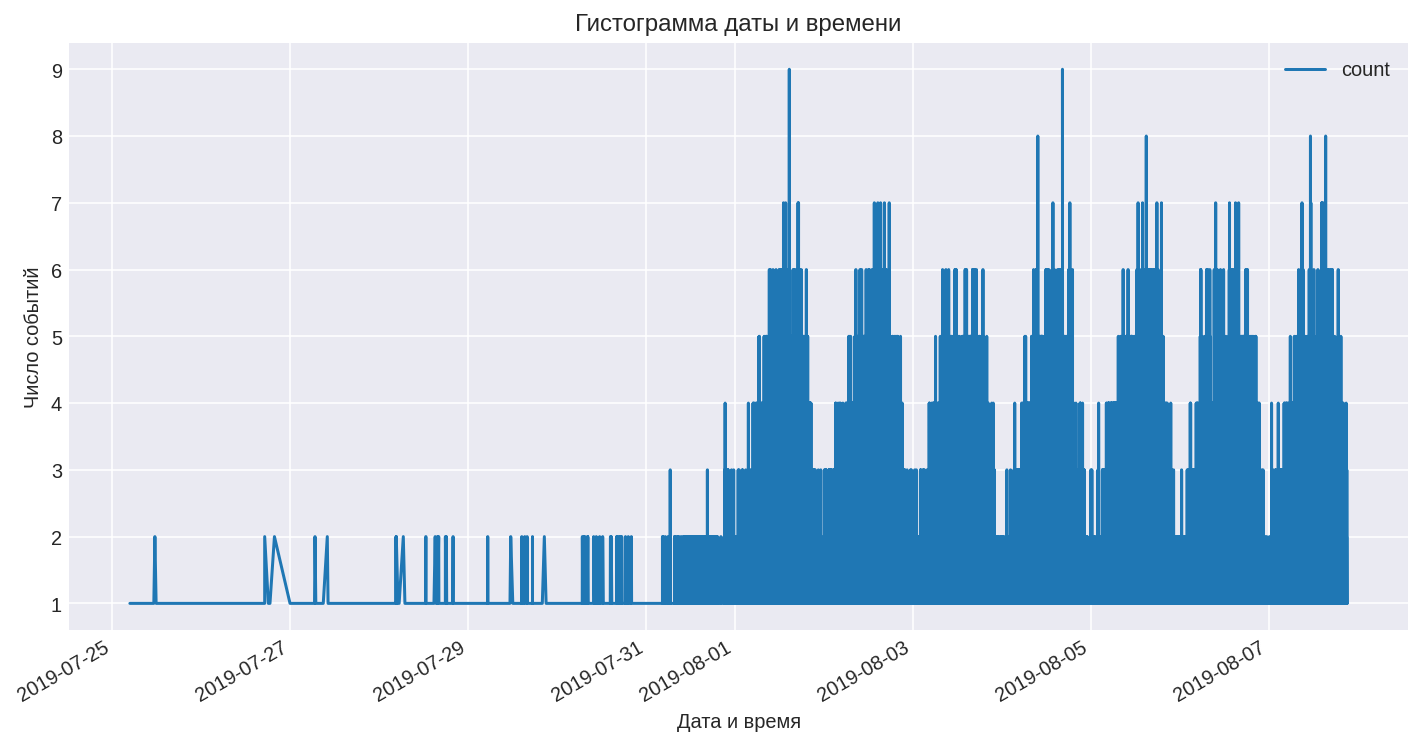

In [21]:
df.groupby('event_timestamp')['event_name'].agg(['count']).sort_values(
by='count', ascending=False).plot(grid=True, title="Гистограмма даты и времени", figsize=(12, 6))
plt.xlabel('Дата и время')
plt.ylabel('Число событий')
plt.show()

Данные за весь период неполные, наибольшее число событий после 01.08.2019, поэтому сделаем срез по этой дате:

In [22]:
df_complete = df.query('event_timestamp >= "2019.08.01"')

Получили таблицу, которая содержит данные за одну неделю с 1 по 7 августа.

Посмотрим как изменились данные по количеству событий:

In [23]:
print("Осталось событий:", df_complete['event_name'].count())
print("Количество удалённых событий:",
      df['event_name'].count() - df_complete['event_name'].count())
print("Процент удаленных событий:",
      "{0:.2%}".format((df['event_name'].count() - df_complete['event_name'].count())/
                       df['event_name'].count()))

Осталось событий: 240887
Количество удалённых событий: 2826
Процент удаленных событий: 1.16%


Посмотрим данные по пользователям:

In [24]:
users_count = df_complete['user_id'].nunique()
print("Осталось пользователей:", users_count)
print("Количество удалённых пользователей:",
      df['user_id'].nunique() - df_complete['user_id'].nunique())
print("Процент удаленных пользователей:",
      "{0:.2%}".format((df['user_id'].nunique() - df_complete['user_id'].nunique())/
                       df['user_id'].nunique())
     )

Осталось пользователей: 7534
Количество удалённых пользователей: 17
Процент удаленных пользователей: 0.23%


Проверим, что пользователи есть в каждой экспериментальной группе:

In [25]:
df_complete.groupby('exp_id')['user_id'].agg(['nunique'])

,nunique
exp_id,
246,2484
247,2513
248,2537


<div style="border: solid green 2px; padding: 20px">

**Выводы**
 * Определили дату, до которой данные были неполными, и сделали срез таблицы с полной информацией за одну неделю.
 * Нашли общее число событий и пользователей для новых данных (240887 и 7534 соответственно), всего удалено 1,16% событий и 0,23% пользователей.
 * Проверили, что пользователи есть в каждой группе.

<a name="4"><h2>4 Исследование воронки событий</h2></a>

Подсчитаем количество событий:

In [26]:
df_complete['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Посмотрим, сколько пользователей совершали каждое из событий и рассчитаем долю пользователей, которые хоть раз совершили событие от их общего числа:

In [27]:
group_unique_users = df_complete.groupby('event_name')['user_id'].agg(['nunique']).sort_values(by='nunique', ascending=False).reset_index()
group_unique_users['percent'] = (group_unique_users['nunique']*100/users_count).round(2)
group_unique_users

,event_name,nunique,percent
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


Вероятнее всего события проходят в следующей очередности: 
* MainScreenAppear (главный экран)
* OffersScreenAppear (вывод предложений на экране)
* CartScreenAppear (корзина)
* PaymentScreenSuccessful (оплата)

Руководство могут использовать не все пользователи, поэтому событие Tutorial необязательное и не относится к воронке, значит его нужно исключить из расчётов.

Сделаем срез таблицы group_unique_users:

In [28]:
group_unique_users = group_unique_users.query('event_name != "Tutorial"')

Построим график воронки событий:

In [29]:
fig = go.Figure(
    go.Funnel(y=group_unique_users['event_name'],
              x=group_unique_users['nunique'], textposition = "inside",
              textinfo = "value+percent initial+percent previous",
              texttemplate = "%{value}<br>%{percentInitial:.1%}(percent of initial)<br>%{percentPrevious:.1%}(percent of previous)",))
fig.update_layout(title="Воронка событий")
fig.show()

<div style="border: solid green 2px; padding: 20px">

**Выводы**
    
Больше всего пользователей (38,1%) теряется на втором шаге при переходе с главного экрана в каталог предложений. До оплаты доходит 47,7% пользователей.

Также вывели на графике долю пользователей, которые переходят на следующий шаг от числа пользователей на предыдущем шаге:
* С главного экрана (MainScreenAppear) в каталог (OffersScreenAppear) переходит 61,9%
* Из каталога (OffersScreenAppear) в корзину (CartScreenAppear) переходит 81,3%
* Из корзины (CartScreenAppear) к оплате (PaymentScreenSuccessful) переходит 94,8%  

<a name="5"><h2>5 Исследование результатов эксперимента</h2></a>

<a name="5.1"><h3>5.1 Число пользователей в группах</h3></a>

Создадим таблицу с количеством уникальных пользователей в каждой экспериментальной группе:

In [30]:
exp_group = df_complete.groupby('exp_id').agg({'user_id' : 'nunique'})
exp_group

,user_id
exp_id,
246,2484
247,2513
248,2537


Добавим в таблицу строчку с общей суммой контрольных групп:

In [31]:
new_row = pd.Series(data={'user_id':exp_group.iloc[0,0] + exp_group.iloc[1,0]}, name='246+247')
exp_group = exp_group.append(new_row, ignore_index=False)

Заменим формат столбца с индексами на формат строки:

In [32]:
exp_group.index = exp_group.index.astype(str)

Проверим таблицу:

In [33]:
exp_group

,user_id
exp_id,
246,2484
247,2513
248,2537
246+247,4997


Проверим, есть ли пользователи, которые попали в разные группы:

In [34]:
dubl_users = df_complete.drop_duplicates(subset=['user_id', 'exp_id'])
dubl_users = dubl_users.groupby('user_id', as_index=False)['exp_id'].count().query('exp_id >= 2')
dubl_users

,user_id,exp_id


Задублированных пользователей нет.

<a name="5.2"><h3>5.2 Проверка разницы между выборками A/A</h3></a>

Для проверки, существует ли разница в долях между выборками, сформулируем гипотезы:

* H₀: различий в долях между группами нет.
* H₁: между долями есть разница.

Сделаем срез таблицы df_complete, исключив событие "Tutorial":

In [35]:
df_complete = df_complete.query('event_name != "Tutorial"')

Создадим сводную таблицу для сравнения групп по событиям:

In [36]:
events_by_groups = df_complete.pivot_table(index='event_name', columns='exp_id', values='user_id', aggfunc='nunique') 
events_by_groups.columns = ['246', '247', '248']
events_by_groups['246+247'] = events_by_groups['246'] + events_by_groups['247']
events_by_groups = events_by_groups.sort_values(by='246', ascending=False)
events_by_groups 

,246,247,248,246+247
event_name,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358


Создадим функцию для сравнения групп по событиям от общего числа пользователей в каждой группе. Для проверки гипотез будем использовать Z-test о проверке гипотезы о равенстве долей:

In [37]:
events = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful']
def z_test(group_one, group_two):
    for event in events:
        # массивы с данными о количестве пользователей в группах и их общим количеством:
        successes = np.array([events_by_groups.loc[event, group_one],
                   events_by_groups.loc[event, group_two]])
        trials = np.array([exp_group.loc[group_one,'user_id'],
                      exp_group.loc[group_two,'user_id']])
        # пропорция успехов в первой группе:
        p1 = successes[0]/trials[0]
        # пропорция успехов во второй группе:
        p2 = successes[1]/trials[1] 
        # пропорция успехов в комбинированном датасете:
        p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
        # разница пропорций в датасетах
        difference = p1 - p2
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)
        # критический уровень статистической значимости 0,05
        alpha = .05
        # считаем p_value
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        # проверяем гипотезу:
        print(event, 'p-значение:', p_value) 
        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        print()

Обратимся к функции и проверим разницу для групп A/A (246 и 247) по событиям:

In [38]:
z_test('246', '247')

MainScreenAppear p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



<div style="border: solid green 2px; padding: 20px">

**Вывод**
  
Для каждого события p-value больше 0.05, поэтому нулевую гипотезу не отвергаем и значит разницы между контрольными группами нет.

<a name="5.3"><h3>5.3 Проверка контрольных групп и группы с изменённым шрифтом</h3></a>

Сформулируем гипотезы:

* H₀: различий между группами A/B нет.
* H₁: различия между группами A/B есть.

Проверим разницу для групп 246 и 248 по событиям:

In [39]:
z_test('246', '248')

MainScreenAppear p-значение: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Проверим разницу для групп 247 и 248 по событиям:

In [40]:
z_test('247', '248')

MainScreenAppear p-значение: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Проверим разницу между объединенной контрольной группой '246+247' и 248 по событиям:

In [41]:
z_test('246+247', '248')

MainScreenAppear p-значение: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



<div style="border: solid green 2px; padding: 20px">

**Вывод**
  
P-value тоже больше 0.05, поэтому нулевую гипотезу не отвергаем. Применение уровня значимости, равного 0,01 не приведет к изменениям, так как p-value по всем событиям значительно больше 0,05.

<a name="6"><h2>6 Общие выводы</h2></a>

В работе были рассмотрены данные за одну неделю с 01.08.2019 по 07.08.2019.

Выяснили, что до оплаты доходит 47,7% пользователей, при этом при переходе на шаг OffersScreenAppear теряется больше всего пользователей - 38,1%, на следующем шаге CartScreenAppear теряется 11,6% и на шаге PaymentScreenSuccessful, при переходе из корзины к оплате, теряется еще 2,6% пользователей. 

Проверка двух контрольных групп A/A показала, что разницы в показателях нет и тест проведен корректно. В результате проверки гипотез о равенстве долей групп A/B не отвергли нулевую гипотезу об отсутствии различий долей, значит шрифт не повлиял на количество пользователей в событиях и на итоговое количество заказов. Всего проведено 16 проверок: сравнивались 4 группы, в каждой из которых по 4 события.